In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
from functools import partial

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()

mnist_train = mnist_builder.as_dataset(split="train")
mnist_test = mnist_builder.as_dataset(split="test")

info = mnist_builder.info
print(info)




tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/jbabcock/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


Label: 4


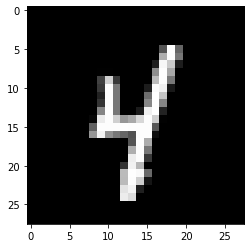

In [20]:
def flatten_image(x, label=False):
    if label:  
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"], (1,28*28)), tf.float32), 256.0) , x["label"])
    else:
        return (tf.divide(tf.dtypes.cast(tf.reshape(x["image"], (1,28*28)), tf.float32), 256.0))

flatten_image = partial(flatten_image, label=True)
    
for image, label in mnist_train.map(flatten_image).take(1):
    plt.imshow(image.numpy().reshape(28,28).astype(np.float32), 
               cmap=plt.get_cmap("gray")
              )
    print("Label: %d" % label.numpy())

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


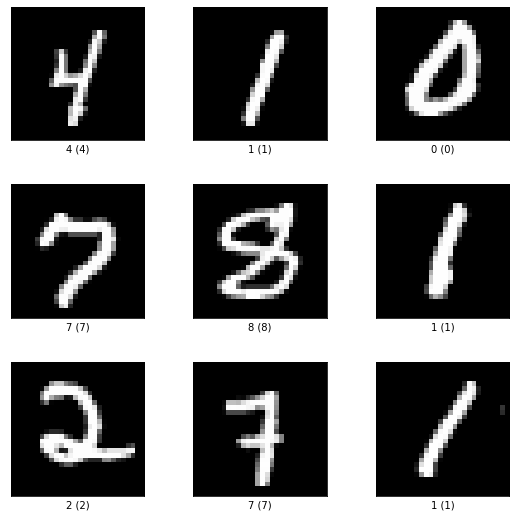

In [21]:
mnist_train.map(flatten_image).take(1)
fig = tfds.show_examples(info, mnist_train)

Label: 4


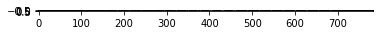

In [12]:
for mnist_example in mnist_train.take(1):
  image, label = mnist_example["image"], mnist_example["label"]

  plt.imshow(image.numpy().ravel().reshape(1,-1).astype(np.float32), cmap=plt.get_cmap("gray"))
  print("Label: %d" % label.numpy())

In [65]:
mnist_train.map(flatten_image).element_spec

(TensorSpec(shape=(1, 784), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [22]:


tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [57]:
class DBN(tf.keras.Model):

    def __init__(self, rbm_params=None, name='deep_belief_network',
                 num_epochs=100, tolerance=1e-3, batch_size=32,
                 shuffle_buffer=1024, **kwargs):
        super().__init__(name=name, **kwargs)
        self._rbm_params = rbm_params
        self._rbm_layers = list()
        self._dense_layers = list()
        for num, rbm_param in enumerate(rbm_params):
            self._rbm_layers.append(RBM(**rbm_param))
            self._rbm_layers[-1].build([rbm_param["number_visible_units"]])
            if num < len(rbm_params)-1:
                self._dense_layers.append(
                    tf.keras.layers.Dense(
                                          rbm_param["number_hidden_units"],
                                          activation=tf.nn.sigmoid)
                )
            else:
                self._dense_layers.append(
                    tf.keras.layers.Dense(
                                          rbm_param["number_hidden_units"],
                                          activation=tf.nn.softmax)
                )
            self._dense_layers[-1].build([rbm_param["number_visible_units"]])
        self._num_epochs = num_epochs
        self._tolerance = tolerance
        self._batch_size = batch_size
        self._shuffle_buffer = shuffle_buffer

    def call(self, x, training):
        for dense_layer in self._dense_layers:
            x = dense_layer(x)
        return x

    def train_rbm(self, rbm, inputs):

        last_cost = None

        for epoch in range(self._num_epochs):
            cost = 0.0
            count = 0.0
            for datapoints in inputs.shuffle(self._shuffle_buffer).batch(
                self._batch_size):
                cost += rbm.cd_update(datapoints)
                count += 1.0
            cost /= count
            print("epoch: {}, cost: {}".format(epoch, cost))
            if last_cost and abs(last_cost-cost) <= self._tolerance:
                break
            last_cost = cost

        return rbm

    def train_dbn(self, inputs):

        # pretraining:
        inputs_layers = []
        for num in range(len(self._rbm_layers)):

            if num == 0:
                inputs_layers.append(inputs)
                self._rbm_layers[num] = \
                    self.train_rbm(self._rbm_layers[num],
                                   inputs)
            else:  # pass all data through previous layer
                inputs_layers.append(inputs_layers[num-1].map(
                    self._rbm_layers[num-1].forward))
                self._rbm_layers[num] = \
                    self.train_rbm(self._rbm_layers[num],
                                   inputs_layers[num])

        # wake-sleep:

        for epoch in range(self._num_epochs):

            # wake pass
            inputs_layers = []
            for num in range(len(self._rbm_layers)):

                if num == 0:
                    inputs_layers.append(inputs)
                else:
                    inputs_layers.append(inputs_layers[num-1].map(
                        self._rbm_layers[num-1].forward))

            for num in range(len(self._rbm_layers)-1):
                cost = 0.0
                count = 0.0
                for datapoints in \
                    inputs_layers[num].shuffle(
                        self._shuffle_buffer).batch(self._batch_size):
                    cost += self._rbm_layers[num].wake_update(datapoints)
                    count += 1.0
                cost /= count
                print("epoch: {}, wake_cost: {}".format(epoch, cost))

            # top-level associative:
            self._rbm_layers[-1] = \
                self.train_rbm(self._rbm_layers[-1],
                               inputs_layers[-2].map(
                                   self._rbm_layers[-2].forward),
                               num_epochs=self._num_epochs,
                               tolerance=self._tolerance,
                               batch_size=self._batch_size,
                               shuffle_buffer=self._shuffle_buffer)

            reverse_inputs = inputs_layers[-1].map(
                self._rbm_layers[-1].forward)

            # sleep pass

            reverse_inputs_layers = []
            for num in range(len(self._rbm_layers)):

                if num == 0:
                    reverse_inputs_layers.append(reverse_inputs)
                else:
                    reverse_inputs_layers.append(
                        reverse_inputs_layers[num-1].map(
                            self._rbm_layers[
                                len(self._rbm_layers)-num].reverse))

            for num in range(len(self._rbm_layers)):
                if num > 0:
                    cost = 0.0
                    count = 0.0
                    for datapoints in \
                        reverse_inputs_layers[num].shuffle(
                            self._shuffle_buffer).batch(self._batch_size):
                        cost += self._rbm_layers[
                            len(self._rbm_layers)-1-num]\
                                .sleep_update(datapoints)
                        count += 1.0
                    cost /= count
                    print("epoch: {}, sleep_cost: {}".format(epoch, cost))

        for dense_layer, rbm_layer in zip(self._dense_layers,
                                          self._rbm_layers):
            dense_layer.set_weights([rbm_layer.w_rec, rbm_layer.hb])


In [58]:
class RBM(tf.keras.layers.Layer):
    def __init__(self, number_hidden_units=10, number_visible_units=None,
                 learning_rate=0.1, cd_steps=1):
        super().__init__()
        self.number_hidden_units = number_hidden_units
        self.number_visible_units = number_visible_units
        self.learning_rate = learning_rate
        self.cd_steps = cd_steps

    def build(self, input_shape):

        if not self.number_visible_units:
            self.number_visible_units = input_shape[-1]

        self.hb = self.add_weight(shape=(self.number_hidden_units, ),
                                  initializer='random_normal',
                                  trainable=True)
        self.vb = self.add_weight(shape=(self.number_visible_units, ),
                                  initializer='random_normal',
                                  trainable=True)
        self.w_rec = self.add_weight(shape=(self.number_visible_units,
                                     self.number_hidden_units),
                                     initializer='random_normal',
                                     trainable=True)
        self.w_gen = self.add_weight(shape=(self.number_hidden_units,
                                     self.number_visible_units),
                                     initializer='random_normal',
                                     trainable=True)

    def call(self, inputs):
        return tf.sigmoid(tf.add(tf.matmul(inputs, self.w_rec), self.hb))

    def free_energy(self, x):
        return -tf.tensordot(x, self.vb, 1)\
               - tf.reduce_sum(
                   tf.math.log(
                       1+tf.math.exp(
                           tf.add(
                               tf.matmul(x, self.w_rec), self.hb))), 1)

    def free_energy_reverse(self, x):
        return -tf.tensordot(x, self.hb, 1)\
               - tf.reduce_sum(
                   tf.math.log(
                       1+tf.math.exp(
                           tf.add(
                               tf.matmul(x, self.w_gen), self.vb))), 1)

    def forward(self, x):
        return tf.sigmoid(tf.add(tf.matmul(x, self.w_rec), self.hb))

    def sample_h(self, x):
        u_sample = tfp.distributions.Uniform().sample((x.shape[1],
                                                       self.hb.shape[-1]))
        return tf.cast(self.forward(x) > u_sample, tf.float32)

    def reverse(self, x):
        return tf.sigmoid(tf.add(tf.matmul(x, self.w_gen), self.vb))

    def sample_v(self, x):
        u_sample = tfp.distributions.Uniform().sample((x.shape[1],
                                                       self.vb.shape[-1]))
        return tf.cast(self.reverse(x) > u_sample, tf.float32)

    def reverse_gibbs(self, x):
        return self.sample_h(self.sample_v(x))

    def forward_gibbs(self, x):
        return self.sample_v(self.sample_h(x))

    def wake_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            h_sample = self.sample_h(x)
            for _ in range(self.cd_steps):
                v_sample = self.sample_v(h_sample)
                h_sample = self.sample_h(v_sample)
            g.watch(self.w_gen)
            g.watch(self.vb)
            cost = tf.reduce_mean(self.free_energy(x)) - tf.reduce_mean(
                self.free_energy_reverse(h_sample))
        w_grad, vb_grad = g.gradient(cost, [self.w_gen, self.vb])

        self.w_gen.assign_sub(self.learning_rate * w_grad)
        self.vb.assign_sub(self.learning_rate * vb_grad)

        return self.reconstruction_cost(x).numpy()

    def sleep_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            v_sample = self.sample_v(x)
            for _ in range(self.cd_steps):
                h_sample = self.sample_h(v_sample)
                v_sample = self.sample_v(h_sample)
            g.watch(self.w_rec)
            g.watch(self.hb)
            cost = tf.reduce_mean(self.free_energy_reverse(x)) - \
                tf.reduce_mean(self.free_energy(v_sample))
        w_grad, hb_grad = g.gradient(cost, [self.w_rec, self.hb])

        self.w_rec.assign_sub(self.learning_rate * w_grad)
        self.hb.assign_sub(self.learning_rate * hb_grad)

        return self.reconstruction_cost_reverse(x).numpy()

    def cd_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:

            h_sample = self.sample_h(x)
            for _ in range(self.cd_steps):
                v_sample = tf.constant(self.sample_v(h_sample))
                h_sample = self.sample_h(v_sample)

            g.watch(self.w_rec)
            g.watch(self.hb)
            g.watch(self.vb)
            cost = tf.reduce_mean(self.free_energy(x)) -\
                tf.reduce_mean(self.free_energy(v_sample))

        w_grad, hb_grad, vb_grad = g.gradient(cost,
                                              [self.w_rec, self.hb, self.vb])

        self.w_rec.assign_sub(self.learning_rate * w_grad)
        self.w_gen = tf.Variable(tf.transpose(self.w_rec))  # force tieing
        self.hb.assign_sub(self.learning_rate * hb_grad)
        self.vb.assign_sub(self.learning_rate * vb_grad)

        return self.reconstruction_cost(x).numpy()

    def reconstruction_cost(self, x):
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.math.add(
                            tf.math.multiply(x,
                                             tf.math.log(
                                                 self.reverse(
                                                     self.forward(x)))),
                            tf.math.multiply(tf.math.subtract(1, x),
                                             tf.math.log(
                                  tf.math.subtract(1, self.reverse(
                                                      self.forward(x)))))
                            ), 1),)

    def reconstruction_cost_reverse(self, x):
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.math.add(
                            tf.math.multiply(x,
                                             tf.math.log(
                                                 self.forward(
                                                     self.reverse(x)))),
                            tf.math.multiply(
                                             tf.math.subtract(1, x),
                                             tf.math.log(
                                                 tf.math.subtract(1, self.forward(self.reverse(x)))))
                            ), 1),)


In [59]:
rbm = RBM(500)
rbm.build([784])
num_epochs=100

def train_rbm(rbm=None, data=mnist_train, map_fn=flatten_image, 
              num_epochs=100, tolerance=1e-3, batch_size=32, shuffle_buffer=1024):

    last_cost = None
    
    for epoch in range(num_epochs):
        cost = 0.0
        count = 0.0
        for datapoints in data.map(map_fn).shuffle(shuffle_buffer).batch(batch_size):
            cost += rbm.cd_update(datapoints)
            count += 1.0
        cost /= count
        print("epoch: {}, cost: {}".format(epoch, cost))
        if last_cost and abs(last_cost-cost) <= tolerance:
            break
        last_cost = cost
    
    return rbm
        
rbm = train_rbm(rbm, mnist_train, partial(flatten_image, label=False), 100, 0.5, 2000)  


KeyboardInterrupt: 

In [60]:
rbm_params = [
        {"number_hidden_units": 500, "number_visible_units": 784},
        {"number_hidden_units": 500, "number_visible_units": 500},
        {"number_hidden_units": 2000, "number_visible_units": 500},
        {"number_hidden_units": 10, "number_visible_units": 2000}
    ]

deep_belief_network = DBN(rbm_params, tolerance=1)

# pre-training and wake-sleep

deep_belief_network.train_dbn(mnist_train.map(
            lambda x: flatten_image(x, label=False)))

# backprop

deep_belief_network.compile(loss=tf.keras.losses.CategoricalCrossentropy())
deep_belief_network.fit(
    x=mnist_train.map(
        lambda x: flatten_image(x, label=True)).batch(1000), )

epoch: 0, cost: -0.2547624500989914
epoch: 1, cost: -0.23773211975892386
epoch: 0, cost: -0.6764357423146565
epoch: 1, cost: -0.6761001986821492


KeyboardInterrupt: 

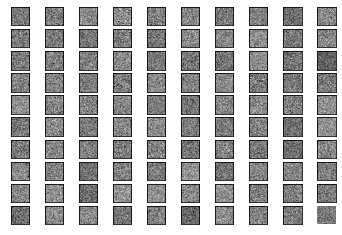

In [48]:
fig, axarr = plt.subplots(10,10)
plt.axis('off')

for i in range(10):
    for j in range(10):
        fig.axes[i*10+j].get_xaxis().set_visible(False)
        fig.axes[i*10+j].get_yaxis().set_visible(False)
        axarr[i,j].imshow(rbm.w_rec.numpy()[:,i*10+j].reshape(28,28), cmap=plt.get_cmap("gray"))


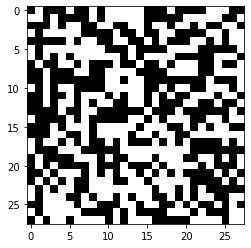

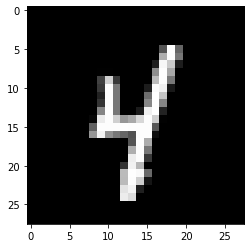

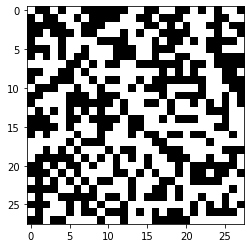

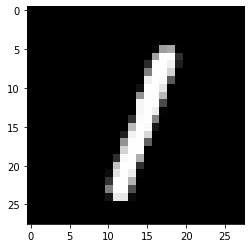

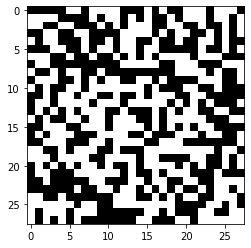

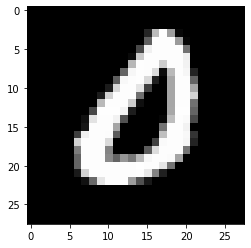

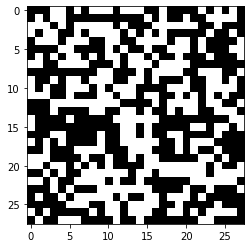

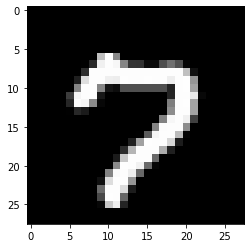

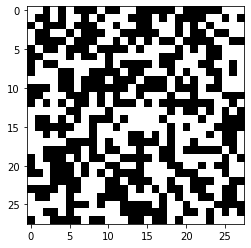

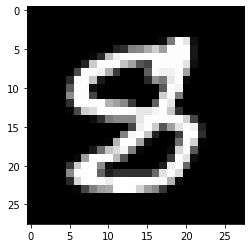

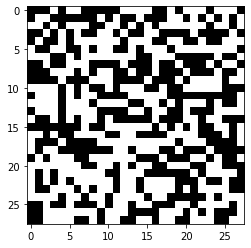

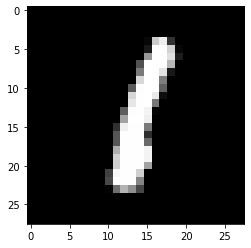

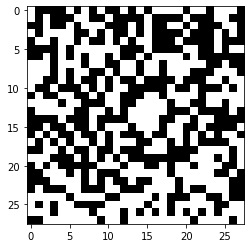

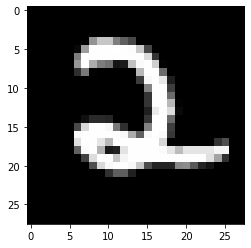

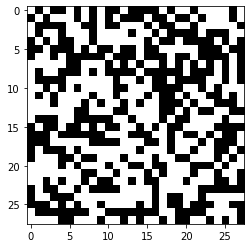

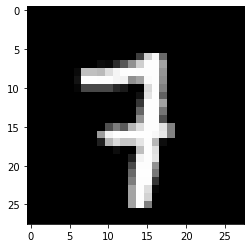

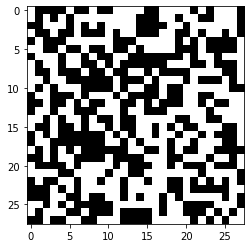

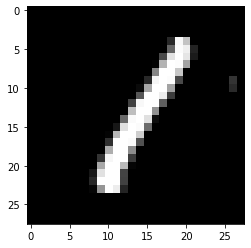

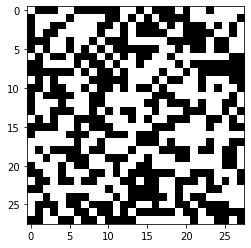

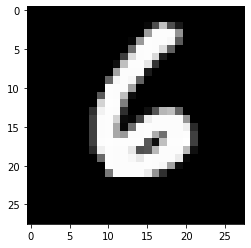

In [49]:
i=0
for image, label in mnist_train.map(flatten_image).batch(1).take(10):
    plt.figure(i)
    plt.imshow(rbm.forward_gibbs(image).numpy().reshape(28,28).astype(np.float32), 
               cmap=plt.get_cmap("gray"))
    i+=1
    plt.figure(i)
    plt.imshow(image.numpy().reshape(28,28).astype(np.float32), 
               cmap=plt.get_cmap("gray"))
    i+=1

mnist_train